# Few-Shot Learning Experiment: ACORD Form to Policy JSON

This notebook demonstrates using Claude to predict insurance policy attributes from ACORD forms using few-shot learning.

## Experiment Overview
- **Training Data**: 5 ACORD forms with corresponding policy JSON representations
- **Test Data**: 1 ACORD form (the 6th one)
- **Method**: Few-shot prompting with Claude Sonnet 4.5
- **Evaluation**: Compare generated JSON against ground truth policy

## Setup

First, let's import the required libraries and set up our environment.

In [1]:
import json
import os
from pathlib import Path
from anthropic import Anthropic
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load environment variables from .env file if it exists
load_dotenv()

print("✓ Imports successful")

✓ Imports successful


## Check API Key

Make sure your Anthropic API key is set in the environment.

In [2]:
api_key = os.environ.get('ANTHROPIC_API_KEY')
if not api_key:
    raise ValueError(
        "ANTHROPIC_API_KEY not found in environment.\n"
        "Please set it by:\n"
        "1. Creating a .env file with: ANTHROPIC_API_KEY=your-key-here\n"
        "2. Or setting it in your shell: export ANTHROPIC_API_KEY='your-key-here'"
    )
print("✓ API key found")

✓ API key found


## Step 1: Load Training Examples

Load the first 5 ACORD forms and their corresponding policy JSONs as training examples.

In [ ]:
def load_training_examples():
    """Load the first 5 ACORD forms and their corresponding policies as training examples."""
    training_data = []
    base_path = Path('data')
    
    for i in range(1, 6):
        acord_path = base_path / f'acord_form_{i}.txt'
        policy_path = base_path / f'policy_{i}.json'
        
        with open(acord_path, 'r') as f:
            acord_form = f.read()
        with open(policy_path, 'r') as f:
            policy_json = f.read()
            
        training_data.append({
            'acord_form': acord_form,
            'policy_json': policy_json
        })
    
    return training_data

training_data = load_training_examples()
print(f"✓ Loaded {len(training_data)} training examples")

# Show a preview of the first training example
print("\n" + "="*80)
print("PREVIEW: First Training Example")
print("="*80)
print("\nACORD Form (first 500 chars):")
print(training_data[0]['acord_form'][:500])
print("\n...\n")
print("Policy JSON (first 500 chars):")
print(training_data[0]['policy_json'][:500])
print("\n...")

## Step 2: Load Test Case

Load the 6th ACORD form (test case) and its ground truth policy.

In [ ]:
def load_test_case():
    """Load the 6th ACORD form (test case) and ground truth policy."""
    base_path = Path('data')
    
    with open(base_path / 'acord_form_6.txt', 'r') as f:
        test_acord = f.read()
    with open(base_path / 'policy_6.json', 'r') as f:
        ground_truth = json.load(f)
    
    return test_acord, ground_truth

test_acord, ground_truth = load_test_case()
print("✓ Test case loaded")
print(f"\nTest ACORD form length: {len(test_acord)} characters")
print(f"Ground truth policy has {len(ground_truth)} top-level fields")

## Step 3: Create Few-Shot Prompt

Construct a prompt that includes all training examples followed by the test case.

In [5]:
def create_prompt(training_data, test_acord):
    """Create the few-shot prompt for the LLM."""
    prompt = """You are an insurance underwriting expert. Your task is to generate a JSON policy representation based on an ACORD insurance application form.

I will show you 5 examples of ACORD forms and their corresponding policy JSON representations. Then, you will generate a policy JSON for a new ACORD form.

"""
    
    # Add training examples
    for i, example in enumerate(training_data, 1):
        prompt += f"=== EXAMPLE {i} ===\n\n"
        prompt += f"ACORD FORM:\n{example['acord_form']}\n\n"
        prompt += f"CORRESPONDING POLICY JSON:\n{example['policy_json']}\n\n"
        prompt += "=" * 80 + "\n\n"
    
    # Add test case
    prompt += """Now, based on the patterns you've observed in the examples above, generate a policy JSON for this new ACORD form:

TEST ACORD FORM:
"""
    prompt += test_acord
    prompt += "\n\nGenerate the policy JSON following the same structure and logic as the examples. Return ONLY the JSON, no additional text."
    
    return prompt

prompt = create_prompt(training_data, test_acord)
print(f"✓ Prompt created")
print(f"\nPrompt length: {len(prompt):,} characters")
print(f"Estimated tokens: ~{len(prompt) // 4:,}")

✓ Prompt created

Prompt length: 35,698 characters
Estimated tokens: ~8,924


## Step 4: Generate Policy with Claude

Call the Claude API to generate the policy JSON for the test ACORD form.

In [7]:
def generate_policy_with_claude(prompt, api_key):
    """Use Claude to generate the policy JSON."""
    client = Anthropic(api_key=api_key)
    
    print("Calling Claude API...")
    message = client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=4096,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    
    return message.content[0].text

try:
    generated_text = generate_policy_with_claude(prompt, api_key)
    
    # Extract JSON from response (in case there's extra text)
    start_idx = generated_text.find('{')
    end_idx = generated_text.rfind('}') + 1
    json_text = generated_text[start_idx:end_idx]
    
    generated_policy = json.loads(json_text)
    print("✓ Policy JSON generated successfully")
    
    # Save generated policy
    with open('generated_policy_6.json', 'w') as f:
        json.dump(generated_policy, f, indent=2)
    print("✓ Generated policy saved to: generated_policy_6.json")
    
    # Display preview
    print("\nGenerated Policy Preview:")
    print(json.dumps(generated_policy, indent=2)[:500] + "\n...")
    
except Exception as e:
    print(f"✗ Error generating policy: {e}")
    raise

Calling Claude API...
✓ Policy JSON generated successfully
✓ Generated policy saved to: generated_policy_6.json

Generated Policy Preview:
{
  "policy_number": "CMP-2024-778945",
  "effective_date": "04/15/2024",
  "expiration_date": "04/15/2025",
  "insured": {
    "business_name": "FitLife Wellness Center LLC",
    "dba": "FitLife",
    "address": "3300 Ocean Boulevard, Miami, FL 33139",
    "federal_id": "65-2345678",
    "industry_code": "713940",
    "industry_description": "Fitness and Recreational Sports Centers"
  },
  "policy_type": "Business Owners Policy (BOP) with Professional Liability",
  "premium": {
    "total_annua
...


## Step 5: Compare Generated Policy with Ground Truth

Analyze the differences between the generated policy and the ground truth.

In [8]:
def flatten_dict(d, parent_key='', sep='.'):
    """Flatten nested dictionary for easier comparison."""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif isinstance(v, list):
            items.append((new_key, str(v)))
        else:
            items.append((new_key, v))
    return dict(items)

def compare_policies(generated, ground_truth):
    """Compare generated policy with ground truth and calculate metrics."""
    gen_flat = flatten_dict(generated)
    truth_flat = flatten_dict(ground_truth)
    
    # Find common keys
    common_keys = set(gen_flat.keys()) & set(truth_flat.keys())
    gen_only_keys = set(gen_flat.keys()) - set(truth_flat.keys())
    truth_only_keys = set(truth_flat.keys()) - set(gen_flat.keys())
    
    # Calculate matches
    exact_matches = 0
    close_matches = 0
    mismatches = 0
    
    comparison_details = {
        'exact_matches': [],
        'close_matches': [],
        'mismatches': [],
        'missing_in_generated': [],
        'extra_in_generated': []
    }
    
    for key in common_keys:
        gen_val = gen_flat[key]
        truth_val = truth_flat[key]
        
        if gen_val == truth_val:
            exact_matches += 1
            comparison_details['exact_matches'].append({
                'field': key,
                'value': truth_val
            })
        elif isinstance(gen_val, (int, float)) and isinstance(truth_val, (int, float)):
            # Check if numeric values are close (within 10%)
            if truth_val != 0 and abs(gen_val - truth_val) / abs(truth_val) <= 0.10:
                close_matches += 1
                comparison_details['close_matches'].append({
                    'field': key,
                    'generated': gen_val,
                    'ground_truth': truth_val
                })
            else:
                mismatches += 1
                comparison_details['mismatches'].append({
                    'field': key,
                    'generated': gen_val,
                    'ground_truth': truth_val
                })
        else:
            mismatches += 1
            comparison_details['mismatches'].append({
                'field': key,
                'generated': gen_val,
                'ground_truth': truth_val
            })
    
    # Track missing and extra fields
    for key in truth_only_keys:
        comparison_details['missing_in_generated'].append({
            'field': key,
            'ground_truth': truth_flat[key]
        })
    
    for key in gen_only_keys:
        comparison_details['extra_in_generated'].append({
            'field': key,
            'generated': gen_flat[key]
        })
    
    # Calculate metrics
    total_fields = len(truth_flat)
    accuracy = (exact_matches + close_matches) / total_fields if total_fields > 0 else 0
    
    metrics = {
        'total_fields_in_ground_truth': total_fields,
        'total_fields_in_generated': len(gen_flat),
        'exact_matches': exact_matches,
        'close_matches': close_matches,
        'mismatches': mismatches,
        'missing_fields': len(truth_only_keys),
        'extra_fields': len(gen_only_keys),
        'accuracy': accuracy,
        'exact_match_rate': exact_matches / total_fields if total_fields > 0 else 0
    }
    
    return metrics, comparison_details

metrics, details = compare_policies(generated_policy, ground_truth)

# Save detailed comparison
with open('comparison_results.json', 'w') as f:
    json.dump({
        'metrics': metrics,
        'details': details
    }, f, indent=2)

print("✓ Comparison complete")
print("✓ Detailed comparison saved to: comparison_results.json")

✓ Comparison complete
✓ Detailed comparison saved to: comparison_results.json


## Results Summary

Display the key metrics from our comparison.

In [9]:
print("=" * 80)
print("EXPERIMENT RESULTS")
print("=" * 80)
print()
print(f"Overall Accuracy: {metrics['accuracy']:.2%}")
print(f"Exact Match Rate: {metrics['exact_match_rate']:.2%}")
print()
print(f"Total Fields (Ground Truth): {metrics['total_fields_in_ground_truth']}")
print(f"Total Fields (Generated): {metrics['total_fields_in_generated']}")
print()
print(f"Exact Matches: {metrics['exact_matches']}")
print(f"Close Matches: {metrics['close_matches']}")
print(f"Mismatches: {metrics['mismatches']}")
print(f"Missing Fields: {metrics['missing_fields']}")
print(f"Extra Fields: {metrics['extra_fields']}")
print()

# Show sample mismatches
if details['mismatches']:
    print("Sample Mismatches (first 5):")
    for mismatch in details['mismatches'][:5]:
        print(f"  • {mismatch['field']}")
        print(f"    Generated: {mismatch['generated']}")
        print(f"    Expected:  {mismatch['ground_truth']}")
    print()

EXPERIMENT RESULTS

Overall Accuracy: 80.00%
Exact Match Rate: 77.33%

Total Fields (Ground Truth): 75
Total Fields (Generated): 76

Exact Matches: 58
Close Matches: 2
Mismatches: 11
Missing Fields: 4
Extra Fields: 5

Sample Mismatches (first 5):
  • premium.property
    Generated: 1200
    Expected:  2200
  • premium.professional_liability
    Generated: 4200
    Expected:  6500
  • premium.workers_compensation
    Generated: 9800
    Expected:  7200
  • policy_number
    Generated: CMP-2024-778945
    Expected:  CMP-2024-778921
  • policy_type
    Generated: Business Owners Policy (BOP) with Professional Liability
    Expected:  Fitness Center Package Policy



## Visualization: Results Breakdown

Create visualizations to better understand the model's performance.

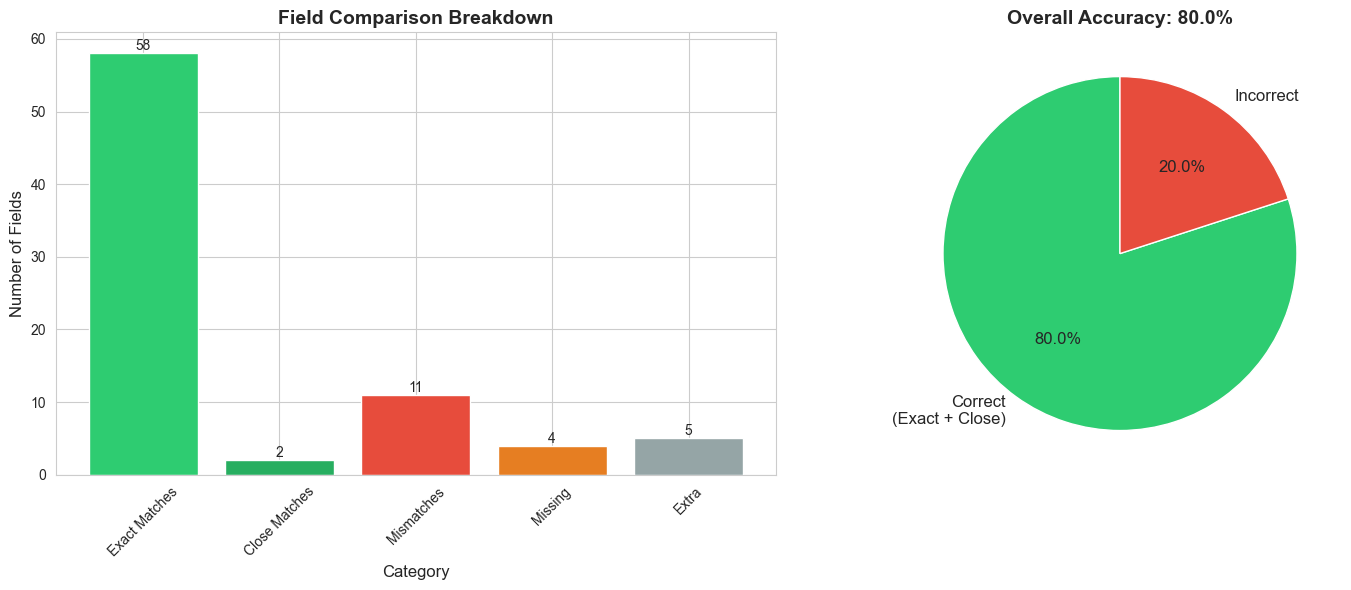

✓ Visualization saved to: experiment_results.png


In [10]:
# Create a DataFrame for plotting
results_data = {
    'Category': ['Exact Matches', 'Close Matches', 'Mismatches', 'Missing', 'Extra'],
    'Count': [
        metrics['exact_matches'],
        metrics['close_matches'],
        metrics['mismatches'],
        metrics['missing_fields'],
        metrics['extra_fields']
    ]
}
df_results = pd.DataFrame(results_data)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
colors = ['#2ecc71', '#27ae60', '#e74c3c', '#e67e22', '#95a5a6']
bars = ax1.bar(df_results['Category'], df_results['Count'], color=colors)
ax1.set_xlabel('Category', fontsize=12)
ax1.set_ylabel('Number of Fields', fontsize=12)
ax1.set_title('Field Comparison Breakdown', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

# Pie chart for accuracy
accuracy_data = {
    'Correct\n(Exact + Close)': metrics['exact_matches'] + metrics['close_matches'],
    'Incorrect': metrics['mismatches'] + metrics['missing_fields']
}
colors_pie = ['#2ecc71', '#e74c3c']
ax2.pie(accuracy_data.values(), labels=accuracy_data.keys(), autopct='%1.1f%%',
       colors=colors_pie, startangle=90, textprops={'fontsize': 12})
ax2.set_title(f'Overall Accuracy: {metrics["accuracy"]:.1%}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('experiment_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: experiment_results.png")

## Analysis: Detailed Mismatch Examination

Let's examine the mismatches more closely to understand where the model struggles.

In [11]:
# Create DataFrames for detailed analysis
if details['mismatches']:
    df_mismatches = pd.DataFrame(details['mismatches'])
    print("Top 10 Mismatches:")
    print(df_mismatches.head(10).to_string(index=False))
    print()
else:
    print("No mismatches found!")

if details['missing_in_generated']:
    df_missing = pd.DataFrame(details['missing_in_generated'])
    print("\nMissing Fields (not generated by model):")
    print(df_missing.head(10).to_string(index=False))
    print()
else:
    print("\nNo missing fields!")

if details['extra_in_generated']:
    df_extra = pd.DataFrame(details['extra_in_generated'])
    print("\nExtra Fields (generated but not in ground truth):")
    print(df_extra.head(10).to_string(index=False))
else:
    print("\nNo extra fields!")

Top 10 Mismatches:
                                                  field                                                                                                                                                                                          generated                                                                                                                                                                                                           ground_truth
                                       premium.property                                                                                                                                                                                               1200                                                                                                                                                                                                                   2200
                         premium.professional_lia

## Conclusion

This experiment demonstrates the effectiveness of few-shot learning for insurance policy prediction. The results can help inform:

1. **Model Performance**: How well does the LLM understand insurance underwriting patterns?
2. **Field Accuracy**: Which policy fields are predicted most/least accurately?
3. **Business Viability**: Is this approach suitable for production use?
4. **Improvement Opportunities**: Where should we focus optimization efforts?

### Next Steps
- Analyze which types of fields (premiums, coverages, limits) are most accurate
- Test with different numbers of training examples
- Try chain-of-thought prompting for better reasoning
- Compare different LLM models
- Implement validation rules for generated policies